In [1]:
import sys
import timeit
import pickle
import codecs
import gensim
import operator
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from matplotlib import font_manager

%matplotlib inline
#plt.rc('text', usetex = True) # use if latex is installed
plt.rcParams['text.latex.unicode'] = True
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["font.size"] = 20

SMALL_SIZE = 14
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fm = mpl.font_manager

myeongjo = 'NanumMyeongjo'
gothic = 'NanumGothic'
number = 'DejaVu Sans'

#[(f.name, f.fname) for f in mpl.font_manager.fontManager.ttflist if 'Nanum' in f.name]

# 색 테마
# https://aesalazar.com/blog/3-professional-color-combinations-for-dashboards-or-mobile-bi-applications/

In [2]:
# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news
natCar = list()
intCar = list()
news = list()

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/korean.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    natCar.append(temp)

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/international.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    intCar.append(temp)

with open('/home/youngwoo/Documents/Media_BigData/figure/news.pickle', 'rb') as fs:
  
    data = pickle.load(fs)

for d in data:
  
    if d['time'] >= datetime.strptime('2016-01-01', '%Y-%m-%d'):
        
        news.append(d)

In [6]:
len(news)

14647

In [147]:
df_nat = pd.DataFrame(natCar)
df_nat['len_reply'] = df_nat['reply'].map(len)
df_nat = df_nat[['title', 'content', 'time', 'reply', 'len_reply']]
df_int = pd.DataFrame(intCar)
df_int['len_reply'] = df_int['reply'].map(len)
df_int = df_int[['title', 'content', 'time', 'reply', 'len_reply']]
df_news = pd.DataFrame(news)
df_news = df_news[['title', 'content', 'time']]

df_bmw = df_int.loc[df_int['content'].str.contains('BMW|bmw|화재|불|리콜|520d|520D')]
#df_bmw = df_int.loc[df_int['content'].str.contains('BMW|bmw')]

df_news_bmw = df_news.loc[df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news.loc[df_news['content'].str.contains('리콜') & df_news['content'].str.contains('BMW|bmw') | df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news_bmw.loc[~df_news_bmw['content'].str.contains('프로모션|이벤트|출시|모터쇼')]
#df_news_bmw = df_news.loc[df_news['content'].str.contains('BMW|bmw')]

df_nat_bmw = df_nat.loc[df_nat['content'].str.contains('화재|불|리콜|520d|520D')]
#df_nat_bmw = df_nat.loc[df_nat['content'].str.contains('BMW|bmw')]

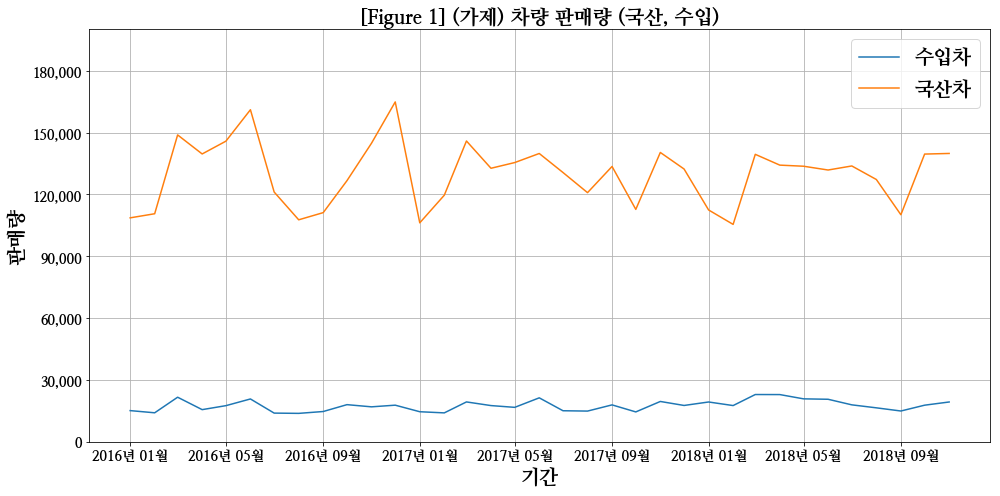

In [148]:
import_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_import_sales_2016.csv', header=0, index_col=0)
import_car_sales = import_car_sales.transpose()
import_car_sales['imported_total'] = import_car_sales.sum(axis=1)

domestic_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_domestic_sales.csv', header=0, index_col=0)
domestic_car_sales = domestic_car_sales.transpose()
domestic_car_sales['domestic_total'] = domestic_car_sales.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales.imported_total, label = '수입차')
ax.plot(pd.to_datetime(domestic_car_sales.T.keys(), format = '%Y%m'), domestic_car_sales.domestic_total, label = '국산차')

ax.set_title(r'[Figure 1] (가제) 차량 판매량 (국산, 수입)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('판매량', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper right', fontsize = 20)
ax.grid(True)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 200000)
ax.set_yticks(np.arange(0, 180000 + 1, 30000))

fig.tight_layout()
plt.show()

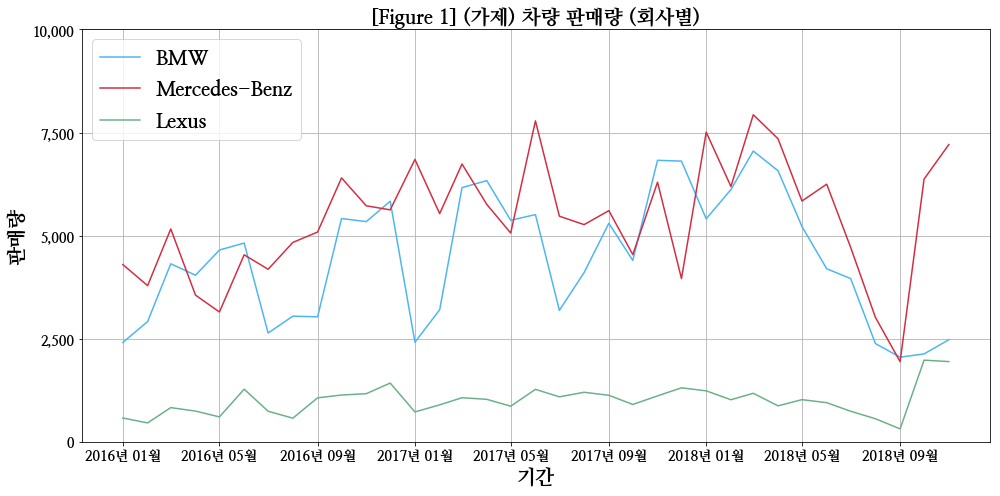

In [149]:
import_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_import_sales_2016.csv', header=0, index_col=0)
import_car_sales = import_car_sales.transpose()
import_car_sales['imported_total'] = import_car_sales.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['BMW'],
        label = 'BMW', color = '#4CB5F5')
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Mercedes-Benz'],
        label = 'Mercedes-Benz', color = '#D32D41')
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Lexus'],
        label = 'Lexus', color = '#6AB187')

ax.set_title(r'[Figure 1] (가제) 차량 판매량 (회사별)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('판매량', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper left', fontsize = 20)
ax.grid(True)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 10000)
ax.set_yticks(np.arange(0, 10000 + 1, 2500))

fig.tight_layout()
plt.show()

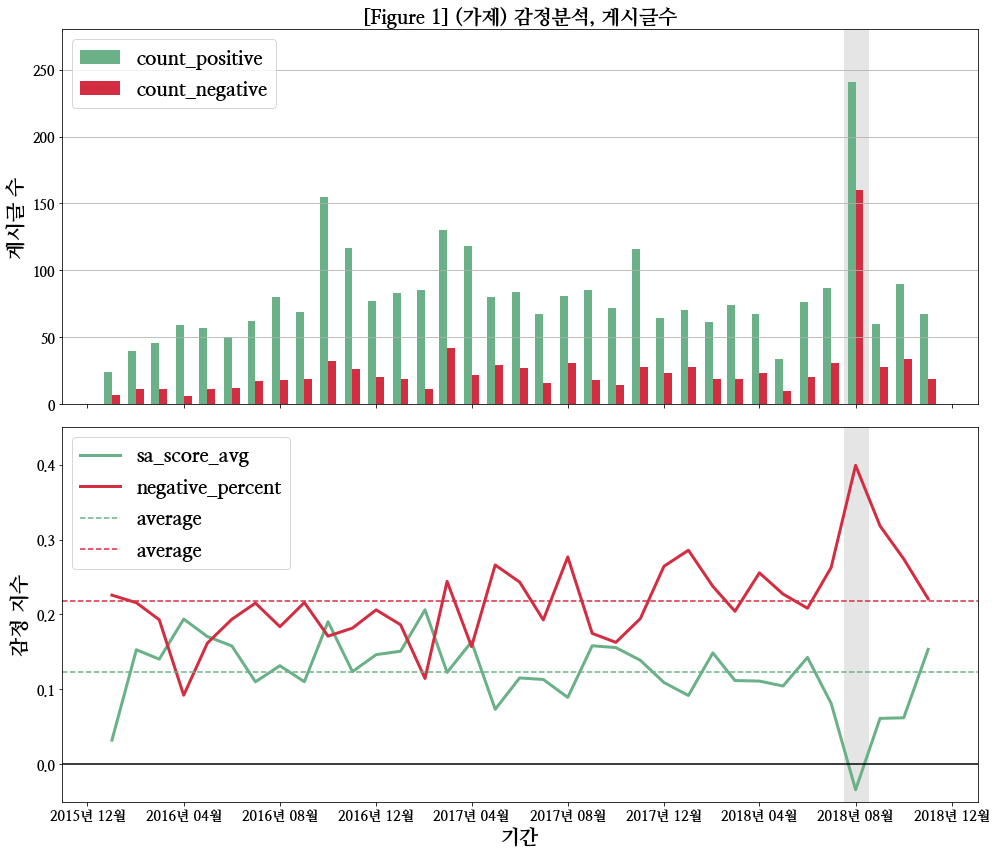

In [150]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_result.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series['count_positive'].T.values, label = 'count_positive', color = '#6AB187', width = 10, zorder = 1)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series['count_negative'].T.values, label = 'count_negative', color = '#D32D41', width = 10, zorder = 1)

ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].plot(pd.to_datetime(pd_series['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series['sa_score_avg'].T.values, label = 'sa_score_avg', color = '#6AB187', lw = 3, zorder = 1)
ax[1].plot(pd.to_datetime(pd_series['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series['negative_percent'].T.values, label = 'negative_percent', color = '#D32D41', lw = 3, zorder = 1)

ax[1].set_xlim(ax[1].get_xlim())
ax[1].plot(ax[1].get_xlim(), [pd_series['sa_score_avg'].T.mean(), pd_series['sa_score_avg'].T.mean()],
         color = '#6AB187', linestyle = '--', label = 'average')
ax[1].plot(ax[1].get_xlim(), [pd_series['negative_percent'].T.mean(), pd_series['negative_percent'].T.mean()],
         c = '#D32D41', linestyle = '--', label = 'average')
ax[1].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[0].set_title(r'[Figure 1] (가제) 감정분석, 게시글수', fontsize = 20, fontname = myeongjo)
ax[0].set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax[0].legend(loc = 'upper left', fontsize = 20)

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax[1].set_ylabel('감정 지수', fontsize = 20, fontname = myeongjo)
ax[1].legend(loc = 'upper left', fontsize = 20)

ax[0].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].set_ylim(0, 280)
ax[0].set_yticks(np.arange(0, 250 + 1, 50))

ax[1].set_ylim(-0.05, 0.45)

fig.tight_layout()
plt.show()

In [151]:
x_nat_year = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                  df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_month = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                   df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_date = pd.DataFrame(x_nat_year, x_nat_month)
x_nat_date['date'] = pd.to_datetime(x_nat_date['year'].astype(int).astype(str) + '-' + x_nat_date.index.astype(int).astype(str))
y_nat = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'), df_nat["time"].dt.month.rename('month')]).count().T[1:].values

x_int_year = df_int['title'].groupby([df_int["time"].dt.year.rename('year'),
                                  df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 0)
x_int_month = df_nat['title'].groupby([df_int["time"].dt.year.rename('year'),
                                   df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 1)
x_int_date = pd.DataFrame(x_int_year, x_int_month)
x_int_date['date'] = pd.to_datetime(x_int_date['year'].astype(int).astype(str) + '-' + x_int_date.index.astype(int).astype(str))
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T[18:].values

x_bmw_year = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                  df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_bmw_month = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                   df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_bmw_date = pd.DataFrame(x_bmw_year, x_bmw_month)
x_bmw_date['date'] = pd.to_datetime(x_bmw_date['year'].astype(int).astype(str) + '-' + x_bmw_date.index.astype(int).astype(str))
y_bmw = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'), df_bmw["time"].dt.month.rename('month')]).count().T[1:].values
y_bmw_ratio = y_bmw[17:] / y_int * 100

x_nat_bmw_year = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                              df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_bmw_month = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                               df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_bmw_date = pd.DataFrame(x_nat_bmw_year, x_nat_bmw_month)
x_nat_bmw_date['date'] = pd.to_datetime(x_nat_bmw_date['year'].astype(int).astype(str) + '-' +
                                        x_nat_bmw_date.index.astype(int).astype(str))
y_nat_bmw = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                         df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].values

x_news_bmw_year = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                  df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_news_bmw_month = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                   df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_news_bmw_date = pd.DataFrame(x_news_bmw_year, x_news_bmw_month)
x_news_bmw_date['date'] = pd.to_datetime(x_news_bmw_date['year'].astype(int).astype(str) + '-' +
                                         x_news_bmw_date.index.astype(int).astype(str))
y_news_bmw = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                           df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].values

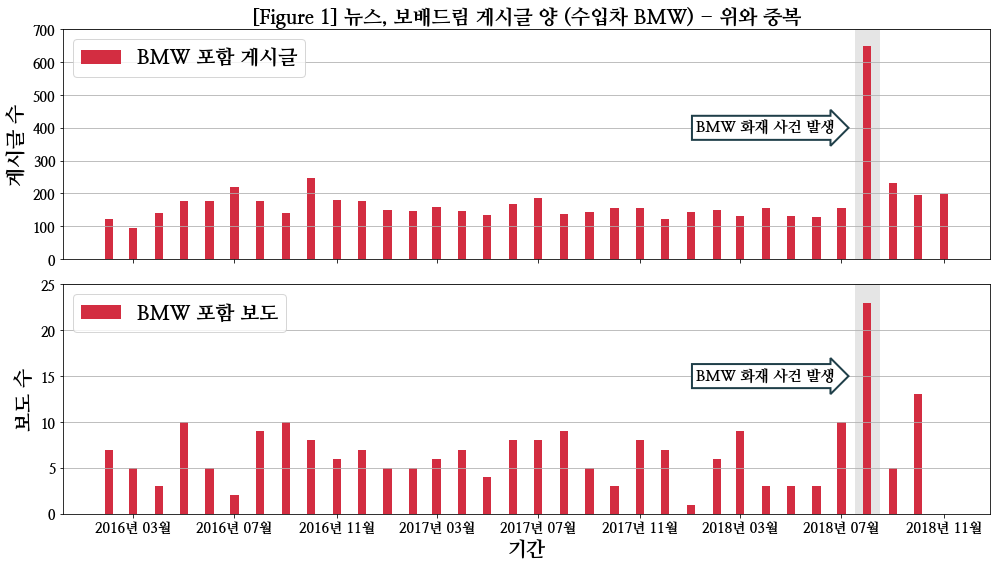

In [152]:
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].bar(x_bmw_date['date'].values, y_bmw, label = 'BMW 포함 게시글', width = 10, color = '#D32D41', zorder = 1)
ax[0].axvline(x = mdates.date2num(x_bmw_date['date'].values)[-4],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[1].bar(x_news_bmw_date['date'].values, y_news_bmw, label = 'BMW 포함 보도', width = 10, color = '#D32D41', zorder = 1)
ax[1].axvline(x = mdates.date2num(x_news_bmw_date['date'].values)[-3],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[0].set_title(r'[Figure 1] 뉴스, 보배드림 게시글 양 (수입차 BMW) - 위와 중복', fontsize = 20, fontname = myeongjo)
ax[0].set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax[0].legend(loc = 'upper left', fontsize = 20)
ax[0].grid(axis = 'y')

ax[1].set_ylabel('보도 수', fontsize = 20, fontname = myeongjo)
ax[1].legend(loc = 'upper left', fontsize = 20)
ax[1].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo)

ax[0].set_ylim(0, 700)
ax[0].set_yticks(np.arange(0, 700 + 1, 100))
ax[1].set_ylim(0, 25)
ax[1].set_yticks(np.arange(0, 25 + 1, 5))

ax[0].text(mdates.date2num(x_bmw_date['date'].values[-8]), 400,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax[1].text(mdates.date2num(x_news_bmw_date['date'].values[-7]), 15,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

fig.tight_layout()
plt.show()

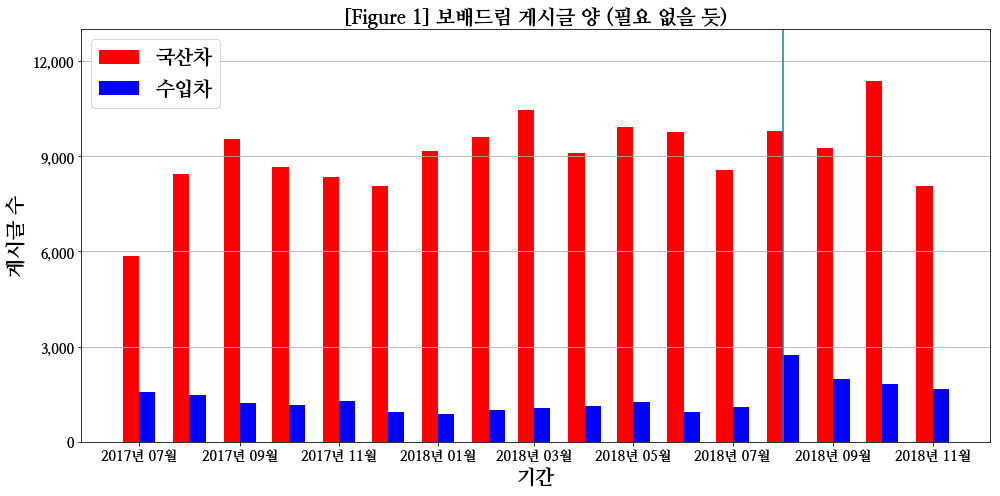

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(x_nat_date['date'].values, y_nat, lw = 0, color = 'r')
ax.bar(mdates.date2num(x_nat_date['date'].values) - 5, y_nat, label = '국산차', width = 10, lw = 3, color = 'r')
ax.bar(mdates.date2num(x_int_date['date'].values) + 5, y_int, label = '수입차', width = 10, lw = 3, color = 'b')
ax.axvline(x = mdates.date2num(x_nat_date['date'].values)[-4])

ax.set_title(r'[Figure 1] 보배드림 게시글 양 (필요 없을 듯)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper left', fontsize = 20)
ax.grid(axis = 'y')

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 13000)
ax.set_yticks(np.arange(0, 13000 + 1, 3000))

fig.tight_layout()
plt.show()

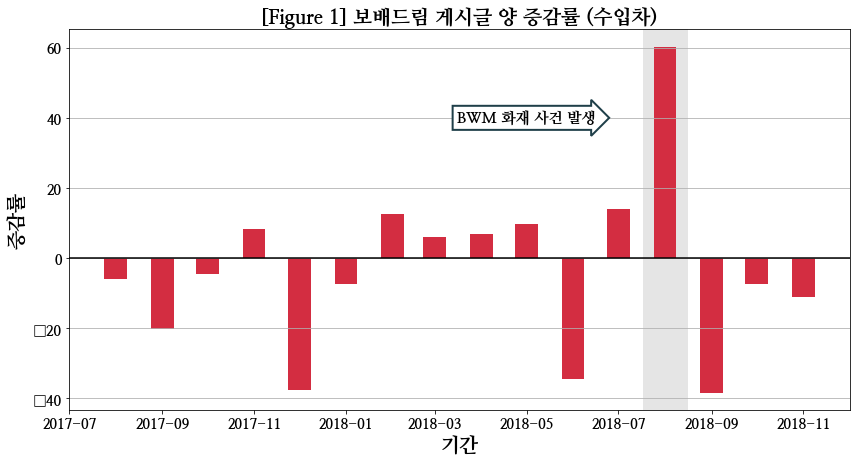

In [10]:
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T[18:].values

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.bar(x_nat_date['date'].values[1:], (y_int[1:] - y_int[:-1]) / y_int[1:] * 100, label = '국산차',
       width = 15, color = '#D32D41', zorder = 1)
ax.axvline(x = mdates.date2num(x_nat_date['date'].values)[-4],
          color = 'gray', lw = 45, alpha = 0.2, zorder = 0)
ax.axhline(y = 0, color = 'k')

ax.set_title(r'[Figure 1] 보배드림 게시글 양 증감률 (수입차)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('증감률', fontsize = 20, fontname = myeongjo)

ax.text(mdates.date2num(x_int_date['date'].values[-7]), 40,
        'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
        bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax.grid(axis = 'y')

In [104]:
okt = Okt()

# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news

# 2018년 8, 9, 월
# 2018년 6, 7 월 로 나눔

before_natCar = list()
before_intCar = list()
before_news = list()
after_natCar = list()
after_intCar = list()
after_news = list()

for d in natCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_natCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_natCar.append(d)
        
    else:
        
        pass
    
for d in intCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_intCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_intCar.append(d)
        
    else:
        
        pass
    
for d in news:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_news.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_news.append(d)
        
    else:
        
        pass

def POS(string):
    
    result = list()
    
    temp = okt.pos(string, norm = True, stem = True)
    
    for t in temp:
        
        # 동사를 넣느냐 넣지 않느냐
        #if t[1] == 'Verb' or t[1] == 'Noun' or t[1] == 'Foreign' or t[1] == 'Adjective':
        #if (t[1] == 'Noun' or t[1] == 'Alpha' or t[1] == 'Adjective') and len(t[0]) > 1:
        if (t[1] == 'Noun' or t[1] == 'Alpha') and len(t[0]) > 1:
            
            result.append(t[0])
            
    return result

def top30word(data, n):
    
    doc = [d['title'].lower() + ' ' + d['content'].lower() for d in data]
    doc_POS = list(map(POS, doc))
    
    word_dict = set(list(itertools.chain.from_iterable(doc_POS)))
    word_dict = set([w for w in word_dict if len(w) > 1])
    
    word_count = {w:sum([d.count(w) for d in doc_POS]) for w in word_dict}
    word_count = sorted(word_count.items(), key = lambda kv : kv[1], reverse = True)

    for d in word_count[:n]:

        print(d)
        
    return doc_POS, word_dict, word_count

print('# of data (before_natCar) : ', len(before_natCar))
print('# of data (before_intCar) : ', len(before_intCar))
print('# of data (before_news)   : ', len(before_news))
print('# of data (after_natCar)  : ', len(after_natCar))
print('# of data (after_intCar)  : ', len(after_intCar))
print('# of data (after_news)    : ', len(after_news))

# of data (before_natCar) :  18336
# of data (before_intCar) :  2015
# of data (before_news)   :  792
# of data (after_natCar)  :  19052
# of data (after_intCar)  :  4708
# of data (after_news)    :  544


In [107]:
before_news_tagged = top30word(before_news, 30)

('모델', 1630)
('차량', 1322)
('자동차', 1246)
('고객', 1027)
('통해', 1024)
('적용', 967)
('판매', 918)
('서비스', 892)
('주행', 846)
('오토', 824)
('타이어', 795)
('디자인', 769)
('브랜드', 743)
('제공', 735)
('기술', 734)
('시스템', 721)
('코리아', 651)
('진행', 639)
('출시', 635)
('이번', 633)
('bmw', 631)
('엔진', 628)
('국내', 612)
('suv', 592)
('예정', 570)
('시장', 549)
('한국', 530)
('뉴스', 526)
('현대차', 520)
('위해', 516)


In [111]:
after_news_tagged = top30word(after_news, 30)

('모델', 1367)
('차량', 1062)
('자동차', 877)
('고객', 789)
('통해', 695)
('적용', 673)
('서비스', 629)
('디자인', 619)
('엔진', 616)
('판매', 580)
('오토', 571)
('시스템', 555)
('주행', 547)
('브랜드', 536)
('제공', 511)
('진행', 481)
('타이어', 474)
('예정', 418)
('시장', 418)
('출시', 417)
('현대차', 411)
('한국', 398)
('뉴스', 394)
('성능', 393)
('위해', 374)
('또한', 368)
('기술', 364)
('이번', 364)
('코리아', 360)
('개발', 327)


In [60]:
top30word(before_intCar, 30) # 동사 포함

('하다', 3169)
('있다', 980)
('되다', 781)
('보다', 600)
('이다', 592)
('없다', 586)
('같다', 507)
('좋다', 431)
('차량', 408)
('아니다', 398)
('타다', 341)
('가다', 322)
('생각', 319)
('정도', 317)
('들다', 310)
('벤츠', 294)
('아우디', 276)
('받다', 268)
('나오다', 267)
('않다', 262)
('알다', 252)
('오다', 247)
('부탁드리다', 242)
('가격', 237)
('어떻다', 221)
('그렇다', 208)
('크다', 202)
('구매', 197)
('센터', 186)
('많다', 181)


In [61]:
top30word(after_intCar, 30) # 동사 포함

('하다', 7607)
('있다', 2406)
('되다', 1789)
('보다', 1435)
('없다', 1329)
('이다', 1113)
('아니다', 1030)
('같다', 1002)
('벤츠', 886)
('차량', 819)
('좋다', 802)
('가다', 791)
('타다', 753)
('들다', 671)
('받다', 639)
('않다', 617)
('그렇다', 588)
('정도', 564)
('생각', 544)
('오다', 535)
('나오다', 511)
('크다', 508)
('화재', 508)
('알다', 481)
('사람', 469)
('아우디', 465)
('어떻다', 410)
('비엠', 406)
('차다', 405)
('나다', 399)


In [97]:
before_intCar_tagged = top30word(before_intCar, 30) # 동사 미포함

('차량', 408)
('생각', 319)
('벤츠', 294)
('정도', 285)
('아우디', 276)
('BMW', 246)
('가격', 237)
('구매', 197)
('센터', 186)
('엔진', 176)
('수입', 169)
('모델', 168)
('형님', 167)
('고민', 161)
('지금', 161)
('질문', 144)
('이번', 140)
('수리', 139)
('견적', 139)
('할인', 138)
('주행', 136)
('딜러', 134)
('그냥', 132)
('vs', 132)
('추천', 129)
('문제', 127)
('서비스', 126)
('판매', 123)
('디젤', 123)
('사람', 121)


In [96]:
after_intCar_tagged = top30word(after_intCar, 30) # 동사 미포함

('벤츠', 886)
('차량', 819)
('BMW', 736)
('생각', 544)
('정도', 518)
('화재', 508)
('사람', 469)
('아우디', 465)
('비엠', 406)
('amp', 348)
('문제', 347)
('디젤', 346)
('엔진', 343)
('가격', 328)
('bmw', 324)
('지금', 313)
('그냥', 312)
('수입', 308)
('모델', 286)
('오늘', 274)
('센터', 272)
('리콜', 268)
('이번', 261)
('자동차', 259)
('추천', 251)
('진짜', 245)
('형님', 244)
('때문', 241)
('인증', 238)
('하나', 231)


In [100]:
common_dictionary = Dictionary(before_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in before_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.027*"SUV" + 0.020*"가격" + 0.018*"체인지" + 0.015*"bmw" + 0.015*"생각" + 0.014*"타고" + 0.014*"차량" + 0.013*"벨라"')
(1, '0.038*"추천" + 0.031*"두리" + 0.019*"vs" + 0.018*"스포츠" + 0.018*"옵션" + 0.017*"대기" + 0.017*"suv" + 0.017*"기아"')
(2, '0.039*"견적" + 0.030*"엘지" + 0.019*"요즘" + 0.018*"럭셔리" + 0.017*"흰색" + 0.017*"예전" + 0.016*"재고" + 0.016*"감성"')
(3, '0.012*"차량" + 0.010*"거리" + 0.009*"디딸" + 0.009*"덜덜" + 0.008*"엔진" + 0.006*"부분" + 0.006*"km" + 0.006*"오늘"')


In [120]:
common_dictionary = Dictionary(after_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in after_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.014*"인증" + 0.007*"사람" + 0.006*"추천" + 0.006*"레이크" + 0.005*"댓글" + 0.004*"생각" + 0.004*"벤츠" + 0.004*"골프"')
(1, '0.015*"차량" + 0.013*"BMW" + 0.011*"벤츠" + 0.009*"화재" + 0.007*"리콜" + 0.007*"bmw" + 0.006*"정도" + 0.006*"디젤"')
(2, '0.008*"타이어" + 0.008*"벤츠" + 0.007*"사람" + 0.005*"생각" + 0.005*"아우디" + 0.005*"느낌" + 0.005*"정도" + 0.004*"자동차"')
(3, '0.014*"amp" + 0.007*"형님" + 0.005*"사람" + 0.004*"결혼" + 0.004*"생각" + 0.004*"포드" + 0.004*"구안" + 0.004*"정도"')
